In [1]:
import sqlite3 as sq
import pandas as pd
import matplotlib.pyplot as plt

from scipy.stats import ttest_rel
from statsmodels.sandbox.stats.multicomp import multipletests 

In [2]:
large = 16; med = 14; small = 10
params = {'axes.titlesize': large,
          'legend.fontsize': med,
          'figure.figsize': (15, 8),
          'axes.labelsize': med,
          'xtick.labelsize': small,
          'ytick.labelsize': small,
          'figure.titlesize': large}
plt.rcParams.update(params)
plt.style.use('seaborn-whitegrid')

pd.set_option('display.max_columns', 100)

## 1. Бухгалтерия-Контур. Продажи (план-факт)

Поскольку планы продаж поставлены только в общем объеме продаж по каждому продукту, без учета тарифов и сегментов рынка, сравнивать план можно только с объемом продаж по продукту в целом.

Для анализа возьмем планы продаж для СЦ региона 77 и сгруппируем по месяцам, как в целом, так и в разрезе каждого СЦ.

Для получения данных о фактических продажах продукта возьмем оплаченные счета, выставленные СЦ региона 77, выделим в строках счетов тарифы, относящиеся к продукту, и сгруппируем по СЦ региона и по датам.

In [3]:
%%time
query = '''SELECT a.name sc_name, 
                   p.dt date, 
                   sum(p.plan_amount) plan_amount_sum,
                   sum(p.plan_count) plan_count_sum
            FROM rPlan p
            JOIN Agents a
            ON p.scID = a.scID
            WHERE p.product = 'Бухгалтерия.Контур'
            AND a.regionCode = 77
            GROUP BY a.name, p.dt
                '''

with sq.connect('testDB.sqlite3') as con:
    plan = pd.read_sql(query, con)

CPU times: user 442 ms, sys: 55.8 ms, total: 497 ms
Wall time: 964 ms


Подготовим данные для работы:

- уберем июль 2015, поскольку показатели за этот месяц слишком сильно выбиваются из общего плана и скорее всего  являются выбросом(тем более, не можем оценить, что было до этого)
- добавим признаки месяца и года для группировок
- поделим на 1000, для отображения продаж в тыс.руб.

(для следующих датафреймов проведем аналогичные действия)

In [4]:
plan = plan[plan['date'] != '2015-06-01']

plan.date = pd.to_datetime(plan.date)
plan.plan_amount_sum = plan.plan_amount_sum/1000

plan['year'] = plan.date.dt.year
plan['month'] = plan.date.dt.month

plan.head()

,sc_name,date,plan_amount_sum,plan_count_sum,year,month
1,Adnipicator International Inc,2015-07-01,1643.1892,108,2015,7
2,Adnipicator International Inc,2015-08-01,1138.9241,87,2015,8
3,Adnipicator International Inc,2015-09-01,744.7514,61,2015,9
4,Adnipicator International Inc,2015-10-01,1131.2800,92,2015,10
5,Adnipicator International Inc,2015-11-01,1064.8550,98,2015,11


In [5]:
# Общий план, сгруппированный по датам

date_group = plan.groupby(plan.date).sum()

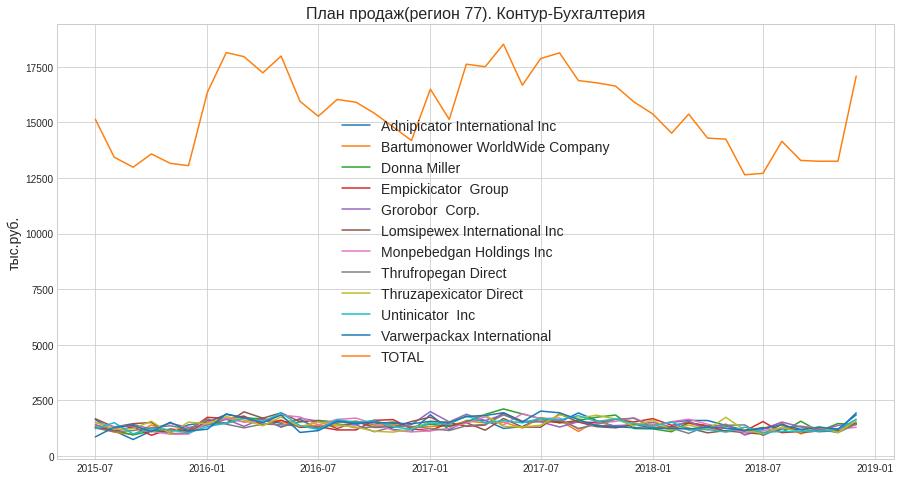

In [6]:
for sc in plan.sc_name.unique():
    plt.plot(plan[plan.sc_name == sc].date, plan[plan.sc_name == sc].plan_amount_sum, label = sc)
    
plt.plot(date_group.plan_amount_sum, label = 'TOTAL')

plt.legend()
plt.ylabel('тыс.руб.')
plt.title('План продаж(регион 77). Контур-Бухгалтерия')
plt.show()

#### Данные по продажам соберем в 3 этапа:

1. Сделаем выгрузку из BillsContent по строкам в счетах, которые относятся только к тарифам продуктов Контур.Бухгалтерия, Эльба и Контур-Экстерн (bills_content). Данные по Эльбе и КЭ могут пригодится позже при оценке рынка сдачи отчестности ИП, поскольку эти продукты также могут использоваться целевой аудиторией для сдачи отчетности.

In [7]:
%%time
query = ''' SELECT bi.bID bill_ID, 
                    pr.product, 
                    pr.piName tariff, 
                    bi.Cost
            FROM BillsContent bi
            LEFT JOIN PriceItems pr
            ON bi.piID = pr.piID
            WHERE pr.product = 'Бухгалтерия.Контур'
            OR pr.product = 'Эльба'
            OR pr.product = 'Контур-Экстерн'
            OR pr.product = 'Контур-Экстерн Малый Бизнес'
        '''

with sq.connect('testDB.sqlite3') as con:
    bills_content = pd.read_sql(query, con)

CPU times: user 7.72 s, sys: 1.06 s, total: 8.78 s
Wall time: 10.3 s


In [8]:
bills_content.head()

,bill_ID,product,tariff,Cost
0,820CD0B5-3BA8-7189-92D9-484BF1EFDA8E,Контур-Экстерн Малый Бизнес,"Доступ к сервису ""Контур-Экстерн Малый Бизнес""...",4800.0
1,3DDA9E7E-1D54-8690-B028-5231F8CEFB57,Контур-Экстерн Малый Бизнес,"Доступ к сервису ""Контур-Экстерн Малый Бизнес""...",4800.0
2,5B127167-CD7F-0D35-AAE1-4AE601E38164,Контур-Экстерн Малый Бизнес,"Доступ к сервису ""Контур-Экстерн Малый Бизнес""...",4800.0
3,1844102B-0278-A6CD-D077-CD9FAF2F8692,Контур-Экстерн Малый Бизнес,"Доступ к сервису ""Контур-Экстерн Малый Бизнес""...",4800.0
4,C70650CD-D640-660B-D360-081386828754,Контур-Экстерн Малый Бизнес,"Доступ к сервису ""Контур-Экстерн Малый Бизнес""...",4800.0


#### 2. Сделаем выгрузку оплаченных счетов, выставленных СЦ региона 77 (bills77)

In [9]:
%%time
query = ''' SELECT bi.bID bill_ID, 
                c.ogrn, 
                a.name sc_name, 
                bi.PayDate pay_date
            FROM Bills bi
            LEFT JOIN Agents a
            ON bi.scID = a.scID
            LEFT JOIN Clients c
            ON  bi.cID = c.cID
            WHERE a.regionCode = 77
            AND bi.PayDate IS NOT NULL
        '''

with sq.connect('testDB.sqlite3') as con:
    bills77 = pd.read_sql(query, con)

CPU times: user 28.5 s, sys: 12.4 s, total: 41 s
Wall time: 43.3 s


In [10]:
bills77.head()

,bill_ID,ogrn,sc_name,pay_date
0,E474B1A7-93A1-3439-8349-43C9C6584333,116419415339972,Grorobor Corp.,2018-10-08
1,8AC45A47-2CE5-547A-7ECC-B5759AC79881,1577682548643,Grorobor Corp.,2015-10-16
2,7A02CCAE-8559-B057-C97D-E133D980EB7A,2000058448850,Grorobor Corp.,2018-06-21
3,DF9563F0-DAA9-EC22-3697-E15321306778,9029043741185,Grorobor Corp.,2016-03-20
4,8E513A3C-9181-1F58-A35F-2D2C41BBBBF8,1647364060980,Grorobor Corp.,2018-06-06


#### 3. Соберем сводную базу из 2х полученных датафреймов (bills_total)

Используем соединение 'inner' - это уберет счета, выставленные по другим продуктам.

Результат: датафрейм, содержащий данные:
- об оплаченных счетах с датой оплаты, выставленных СЦ региона 77
- с указанием имени СЦ
- с указанием ОГРН клиента (это поможет выделить ИП по длине ОГРН)
- по интересующим нас продуктам и соответствующим тарифам

In [11]:
%%time
bills_total = bills77.merge(bills_content, how = 'inner', on='bill_ID')

CPU times: user 2.72 s, sys: 98.2 ms, total: 2.82 s
Wall time: 2.9 s


In [12]:
# заменим даты оплаты на первое число месяца оплаты(напр. 2018-10-19 --> 2018-10-01), 
# чтобы можно было сопоставлять продажи с планом, с теми же временными метками

bills_total.pay_date = pd.to_datetime(pd.to_datetime(bills_total.pay_date).apply(lambda x: x.strftime('%B-%Y')))

In [13]:
bills_total = bills_total[bills_total['pay_date'] != '2015-06-01']

bills_total.Cost = bills_total.Cost/1000

bills_total['year'] = bills_total.pay_date.dt.year
bills_total['month'] = bills_total.pay_date.dt.month

In [14]:
bills_total.head()

,bill_ID,ogrn,sc_name,pay_date,product,tariff,Cost,year,month
0,E474B1A7-93A1-3439-8349-43C9C6584333,116419415339972,Grorobor Corp.,2018-10-01,Эльба,"Право использования ""Эльба"" сроком на 2 года п...",32.4,2018,10
1,DB6B281C-EC01-AF3B-3DB3-918141068826,6792756234557,Grorobor Corp.,2017-02-01,Эльба,"Право использования ""Эльба"" сроком на 1 год (...",10.8,2017,2
2,CCC1D489-8FAE-E16A-0899-69787D7C078D,352983634769700,Grorobor Corp.,2018-05-01,Эльба,"Право использования ""Эльба"" сроком на 18 мес. ...",24.3,2018,5
3,79575BF6-72EA-E066-B60A-08932D5F9388,142254063403160,Grorobor Corp.,2018-01-01,Эльба,"Право использования ""Эльба"" сроком на 18 мес. ...",24.3,2018,1
4,E84EEAD8-5347-9F5F-C5FD-AF46BFFAB5E2,161136713087696,Grorobor Corp.,2018-06-01,Контур-Экстерн,"Доступ к сервису ""Контур-Экстерн"" сроком на 6 ...",8.1,2018,6


In [15]:
# Общие продажи по месяцам

sales_by_paydate = pd.DataFrame(bills_total[bills_total['product'] == 'Бухгалтерия.Контур']['Cost'].groupby(bills_total.pay_date).sum())
sales_by_paydate['plan'] = date_group.plan_amount_sum

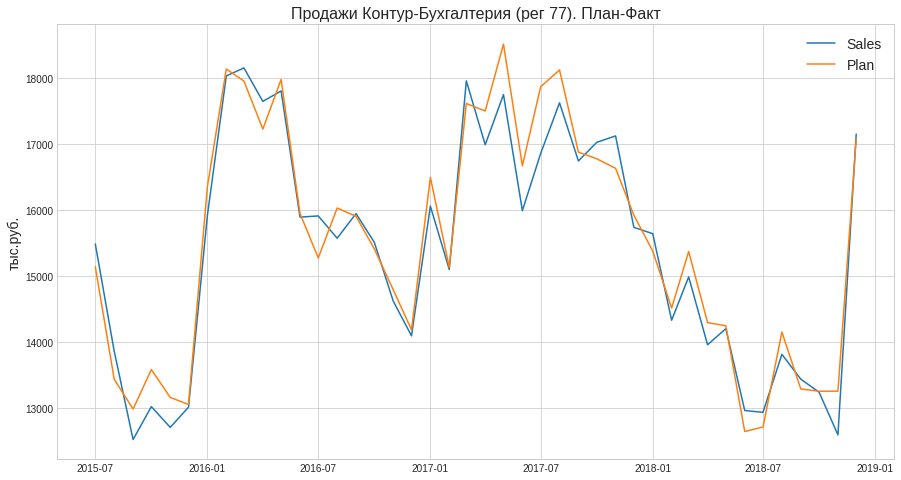

In [16]:
plt.plot(sales_by_paydate.Cost, label = 'Sales')    
plt.plot(sales_by_paydate.plan, label = 'Plan')

plt.legend()
plt.ylabel('тыс.руб.')
plt.title('Продажи Контур-Бухгалтерия (рег 77). План-Факт')

plt.show()

In [17]:
print('Total month Sales mean:', sales_by_paydate.Cost.mean(), 'тыс.руб.')
print('Total month Plan mean:', sales_by_paydate.plan.mean(), 'тыс.руб.')
print('Difference:', sales_by_paydate.Cost.mean() - sales_by_paydate.plan.mean(), 'тыс.руб.')
print(ttest_rel(sales_by_paydate.Cost, sales_by_paydate.plan))

Total month Sales mean: 15382.144523809498 тыс.руб.
Total month Plan mean: 15499.898459523809 тыс.руб.
Difference: -117.7539357143105 тыс.руб.
Ttest_relResult(statistic=-2.0103474059001343, pvalue=0.051003751903093926)


Несмотря на кажущуюся близость плана и факта, критерий Стьюдента говорит о том, что отклонения продаж от плана статистически значимы. План не выполняется. Практически среднее ежемесячное отклонение составляет 117тыс.руб. Что на всем периоде дает потери в 4914тыс.руб. Попробуем определить зоны роста

Поищем статистически значимые отклонения от плана, от тренда по отношению к предыдущему месяцу и по отношению к аналогичному месяцу прошлого года

In [18]:
sales_by_paydate['plan_delta'] = ((sales_by_paydate.Cost)/sales_by_paydate.plan*100).apply(lambda x: round(x,2))
sales_by_paydate['prev_month_delta'] = (sales_by_paydate.Cost/sales_by_paydate.Cost.shift()*100).apply(lambda x: round(x,2))
sales_by_paydate['prev_year_delta'] = (sales_by_paydate.Cost/sales_by_paydate.Cost.shift(12)*100).apply(lambda x: round(x,2))

sales_by_paydate['month'] = sales_by_paydate.index.month
sales_by_paydate['year'] = sales_by_paydate.index.year
sales_by_paydate.head(13)

,Cost,plan,plan_delta,prev_month_delta,prev_year_delta,month,year
pay_date,,,,,,,
2015-07-01,15487.90,15143.9924,102.27,NaN,NaN,7,2015
2015-08-01,13864.59,13439.0571,103.17,89.52,NaN,8,2015
2015-09-01,12523.90,12986.0830,96.44,90.33,NaN,9,2015
2015-10-01,13022.37,13584.6542,95.86,103.98,NaN,10,2015
2015-11-01,12708.53,13161.9528,96.56,97.59,NaN,11,2015
2015-12-01,13013.92,13055.5449,99.68,102.40,NaN,12,2015
2016-01-01,15922.37,16357.1666,97.34,122.35,NaN,1,2016
2016-02-01,18036.76,18141.4898,99.42,113.28,NaN,2,2016
2016-03-01,18158.08,17957.7142,101.12,100.67,NaN,3,2016


In [19]:
plan_delta_mean = sales_by_paydate.describe()['plan_delta']['mean']
plan_delta_std = sales_by_paydate.describe()['plan_delta']['std']

prev_month_delta_mean = sales_by_paydate.describe()['prev_month_delta']['mean']
prev_month_delta_std = sales_by_paydate.describe()['prev_month_delta']['std']

prev_year_delta_mean = sales_by_paydate.describe()['prev_year_delta']['mean']
prev_year_delta_std = sales_by_paydate.describe()['prev_year_delta']['std']

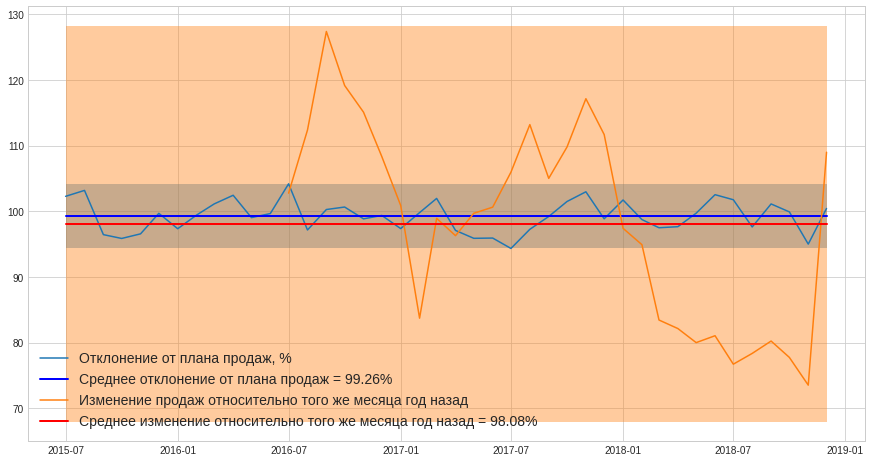

In [20]:
plt.plot(sales_by_paydate['plan_delta'], label = 'Отклонение от плана продаж, %')
plt.plot(sales_by_paydate.index, [plan_delta_mean]*42, lw = 2, color = 'blue', \
                 label = 'Среднее отклонение от плана продаж = {:.2f}%'.format(plan_delta_mean))
plt.fill_between(sales_by_paydate.index, plan_delta_mean-2*plan_delta_std, \
                 plan_delta_mean+2*plan_delta_std, alpha = 0.4)

plt.plot(sales_by_paydate['prev_year_delta'], label = 'Изменение продаж относительно того же месяца год назад')
plt.plot(sales_by_paydate.index, [prev_year_delta_mean]*42, lw = 2, color = 'red', \
                 label = 'Среднее изменение относительно того же месяца год назад = '\
                         '{:.2f}%'.format(prev_year_delta_mean))
plt.fill_between(sales_by_paydate.index, prev_year_delta_mean-2*prev_year_delta_std, \
                 prev_year_delta_mean+2*prev_year_delta_std, alpha = 0.4)

# plt.ylim([50, 150])
plt.legend()
plt.title('');

В целом все изменения в продажах к прошлому году и отклонения от плана укладываются в 95% доверительные интервалы для средних значений.
Однако можно заметить, что изменения относительно предыдущих лет имеют довольно высокую дисперсию, а 2018 год практически весь характеризуется падением продаж, относительно 2017го. 
Однако продажи за этот период укладывались в план, а значит падение продаж было предсказуемо и спрогнозировано заранее.

#### Оценим выполнение планов Сервисными Центрами

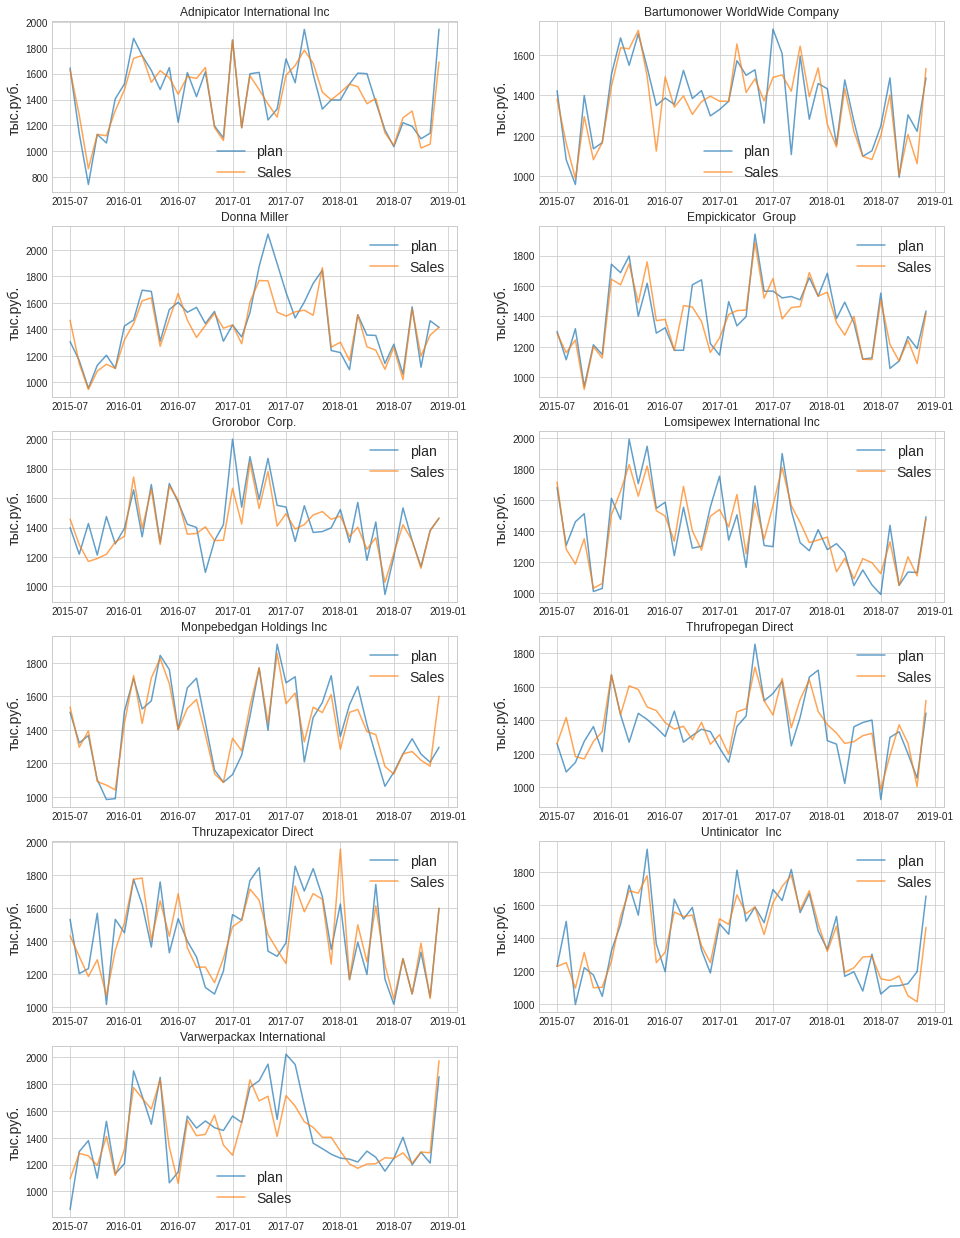

In [21]:
plt.figure(figsize = (16,22))

ttest = []

for i, sc in enumerate(plan.sc_name.unique()):
    plt.subplot(6,2,i+1)
    
    plan_sc = plan[plan.sc_name == sc].plan_amount_sum
    plt.plot(plan[plan.sc_name == sc].date, plan_sc, label = 'plan',  alpha=0.7)
    
    sales_sc = bills_total[(bills_total['product'] == 'Бухгалтерия.Контур') &\
                (bills_total['sc_name'] == sc)]['Cost'].groupby(bills_total.pay_date).sum()
    plt.plot(sales_sc, label = 'Sales',  alpha=0.7)
   
    plt.legend()
    plt.ylabel('тыс.руб.')
    plt.title(sc, fontsize = 12)
    ttest.append((sc, *ttest_rel(sales_sc, plan_sc)))
plt.show()

#### Проанализируем статистически значимые отклонения факта от плана в каждом СЦ
визуально:

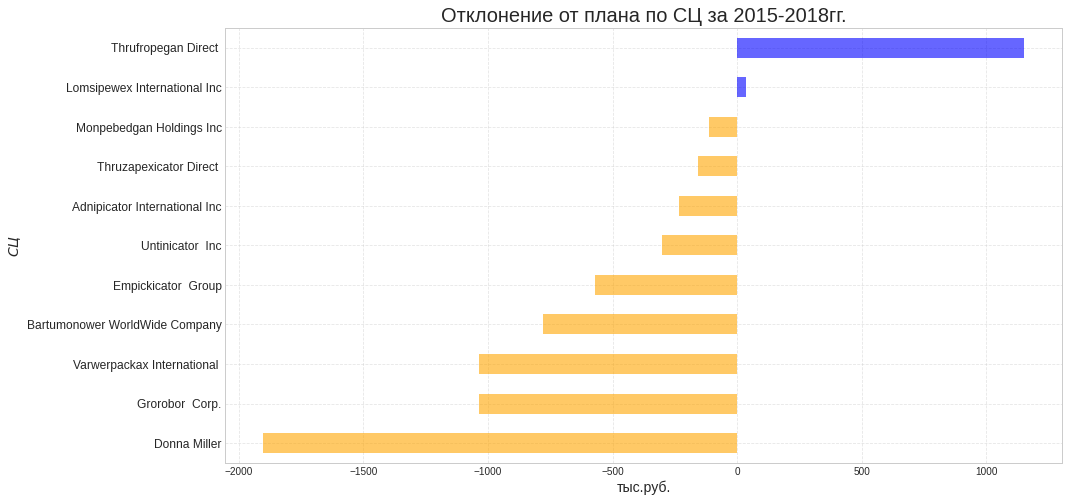

In [22]:
df = pd.DataFrame(bills_total[(bills_total['product'] == 'Бухгалтерия.Контур')].groupby('sc_name')['Cost'].sum() -\
        plan.groupby('sc_name')['plan_amount_sum'].sum(), columns = ['delta'])

df['colors'] = ['orange' if el < 0 else 'blue' for el in df.delta]
df.sort_values('delta', inplace=True)
df.reset_index(inplace=True)

plt.hlines(y=df.index, xmin=0, xmax=df.delta, color=df.colors, alpha=0.6, linewidth=20)

plt.gca().set(ylabel='$СЦ$', xlabel='тыс.руб.')
plt.yticks(df.index, df.sc_name, fontsize=12)
plt.title('Отклонение от плана по СЦ за 2015-2018гг.', fontdict={'size':20})
plt.grid(linestyle='--', alpha=0.5)
plt.show()

Статистически, с учетом множественной проверки гипотез:

In [23]:
sc_plan_stat = pd.DataFrame(ttest, columns = ['sc', 'statistics', 'pvalue'], ).sort_values('pvalue')

In [24]:
reject, p_corrected, a1, a2 = multipletests(sc_plan_stat.pvalue, 
                                            alpha = 0.05, 
                                            method = 'fdr_bh') 

sc_plan_stat['p_corrected'] = p_corrected
sc_plan_stat['reject'] = reject
sc_plan_stat

,sc,statistics,pvalue,p_corrected,reject
2,Donna Miller,-2.722226,0.009478,0.104254,False
7,Thrufropegan Direct,1.529153,0.133906,0.529603,False
4,Grorobor Corp.,-1.407749,0.166743,0.529603,False
10,Varwerpackax International,-1.220005,0.229434,0.529603,False
1,Bartumonower WorldWide Company,-1.190419,0.240729,0.529603,False
3,Empickicator Group,-0.874791,0.386783,0.709103,False
9,Untinicator Inc,-0.494302,0.623731,0.939539,False
0,Adnipicator International Inc,-0.341757,0.734279,0.939539,False
8,Thruzapexicator Direct,-0.210145,0.834595,0.939539,False
6,Monpebedgan Holdings Inc,-0.185019,0.854126,0.939539,False


Гипотеза о выполнении плана за все время не отвергается ни для одного СЦ на уровне значимости 0.05.
Тем не менее, СЦ "Donna Miller" выбивается из общего ряда и на уровне значимости 0.11 гипотеза о выполнении им плана все же может быть отвергнута. 

**То же, по годам**

Данные по продажам за 2015 год есть только за 2е полугодие. 
Для наглядности умножаем их на 2, как в плане, так и в факте, чтобы оценить продажи за весь год. 
Соотношение план-факт для 2015 года от этого не изменится

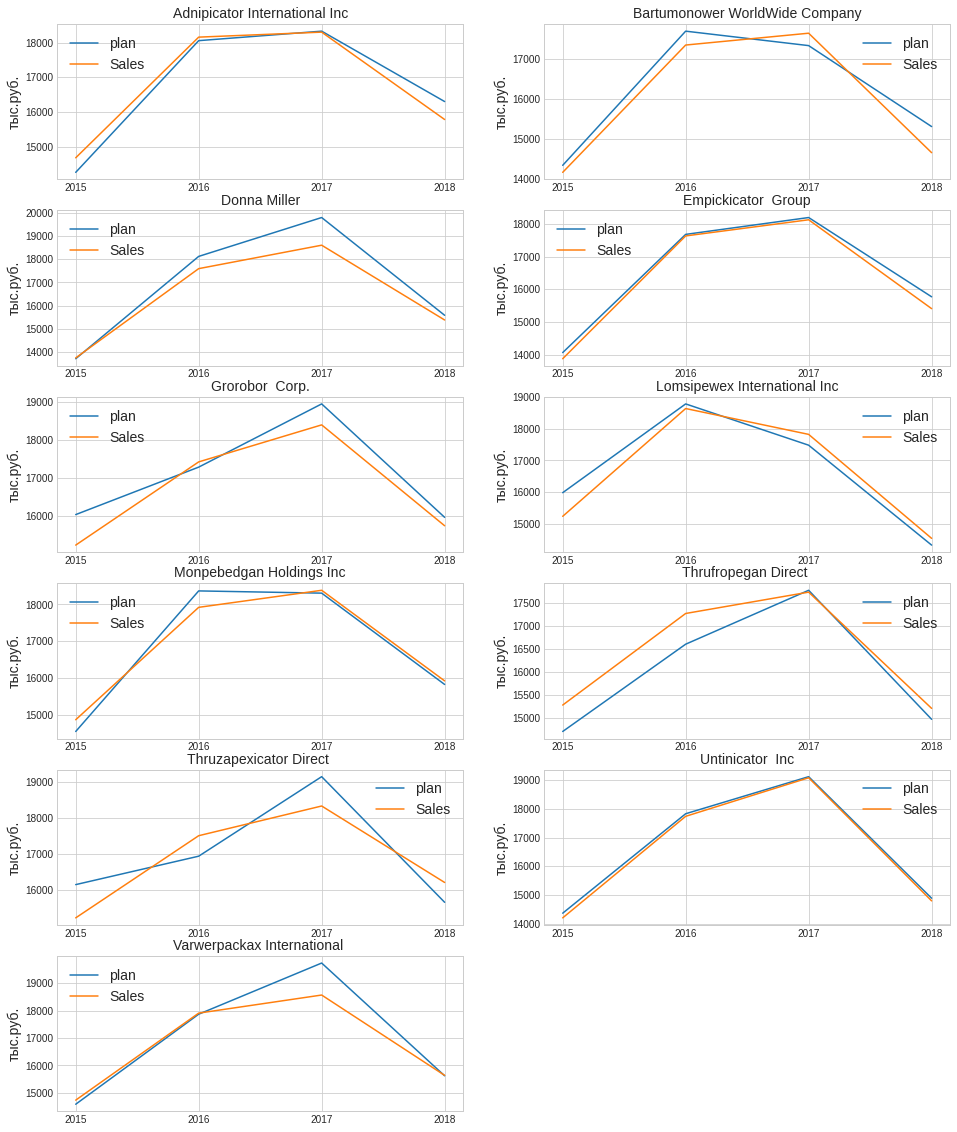

In [25]:
plt.figure(figsize = (16,20))

for i, sc in enumerate(plan.sc_name.unique()):
    plt.subplot(6,2,i+1)
    
    plan_cs_year = plan[plan.sc_name == sc].groupby('year')['plan_amount_sum'].sum()
    plan_cs_year.loc[2015] *=2
    plt.plot(plan_cs_year, label = 'plan')
    
    fact_sc_year = bills_total[(bills_total['product'] == 'Бухгалтерия.Контур') &\
                          (bills_total['sc_name'] == sc)].groupby('year')['Cost'].sum()
    fact_sc_year.loc[2015] *= 2
    plt.plot(fact_sc_year, label = 'Sales')
   
    plt.legend()
    plt.ylabel('тыс.руб.')
    plt.title(sc, fontsize = 14)
    plt.xticks([2015, 2016, 2017, 2018])
    
plt.show()

Здесь так же можно увидеть стабильное невыполнение годового плана СЦ Donna Miller.

Также стоит обратить внимание на  СЦ Bartumonower WorldWide Company, Varwerpackax International и Grorobor Corp.
Статистически их продажи незначительно отклоняются от планов, но большую часть годовых планов они недорабатывают.

Небольшое улучшение продаж этих СЦ могло бы довести выполнение планов до 100%. Либо более мягкие требования к планам продаж, если есть объективные причины невыполнения текущих планов.

### Оценим продажи в разрезе тарифных планов

In [26]:
tariffs = bills_total[bills_total['product'] == 'Бухгалтерия.Контур']\
                        .groupby(bills_total.tariff).agg(['sum', 'mean'])

In [27]:
tariffs['sales_count'] = (tariffs['Cost']['sum']/tariffs['Cost']['mean']).fillna(0).astype(int)
tariffs.sort_values(('Cost', 'sum'), ascending = False, inplace=True)
tariffs = tariffs.reset_index()

# сохраним тарифы, по которым есть продажи в отдельный список 
# и оставим в названии тарифов только срок и тарифный план
tariff_bk = tariffs.tariff.values[:-4]
tariffs.tariff = tariffs.tariff.apply(lambda x: x[48:])
tariffs[['tariff', 'Cost', 'sales_count']]

tariff       Cost            sales_count
                                                    sum       mean            
0                              2 года (Лайт)  316194.25  17.139758       18448
1                             18 мес. (Лайт)  175704.52  12.844837       13679
2         1 год по тарифному плану "Базовый"   78263.99  17.118108        4572
3            1 год по тарифному плану "Лайт"   36864.83   8.565249        4304
4   6 мес. по тарифному плану "Максимальный"   20116.33  12.870333        1563
5                           6 мес. (Базовый)   12677.89   8.577733        1478
6           6 мес. по тарифному плану "Лайт"    6228.26   4.289435        1452
7             1 мес. по тарифному плану "ТД"       0.00   0.000000           0
8             2 мес. по тарифному плану "ТД"       0.00   0.000000           0
9                                3 мес. (ТД)       0.00   0.000000           0
10            4 мес. по тарифному плану "ТД"       0.00   0.000000           0

Результаты упорядочены по убыванию суммы продаж по каждому тарифу.

Заметим, что по количеству продаж данные сортируются в том же порядке.

Продажи по тарифу "ТД" нулевые, однако в выборке уже оставлены счета, по которым стоит дата оплаты! 
Возможно, здесь какая-то ошибка в исходной базе, это надо уточнить.

Пока что тарифы 'ТД' можно отбросить

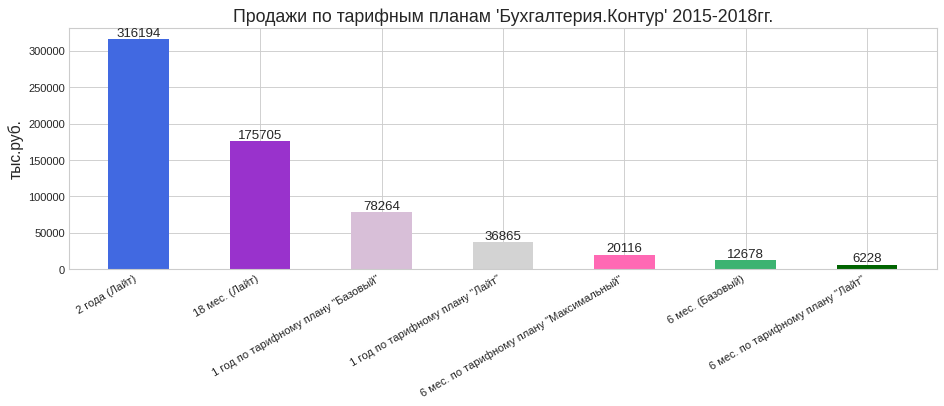

In [28]:
import random
import numpy as np

df = tariffs.replace(0.0, np.nan).dropna()
n = df.tariff.unique().__len__()+1
all_colors = list(plt.cm.colors.cnames.keys())
random.seed(111)
c = random.choices(all_colors, k=n)

plt.figure(figsize=(14,4), dpi= 80)
plt.bar(df.tariff, df['Cost']['sum'], color=c, width=.5)
for i, val in enumerate(df['Cost']['sum'].values):
    plt.text(i, val, round(float(val)), horizontalalignment='center', verticalalignment='bottom', fontdict={'fontweight':500, 'size':12})

plt.gca().set_xticklabels(df.tariff, rotation=30, horizontalalignment= 'right')
plt.title("Продажи по тарифным планам 'Бухгалтерия.Контур' 2015-2018гг.")
plt.ylabel('тыс.руб.')

plt.show()

### Посмотрим динамику продаж по каждому тарифу с общим объемом продаж по годам
Для этого посмотрим графики отнормированных продаж (вычитаем среднее и делим на стандартное отклонение)

In [29]:
sales_years = sales_by_paydate.groupby('year')['Cost'].sum()
sales_years.loc[2015] *=2 
sales_years

year
2015    161242.42
2016    195146.19
2017    201002.97
2018    169279.70
Name: Cost, dtype: float64

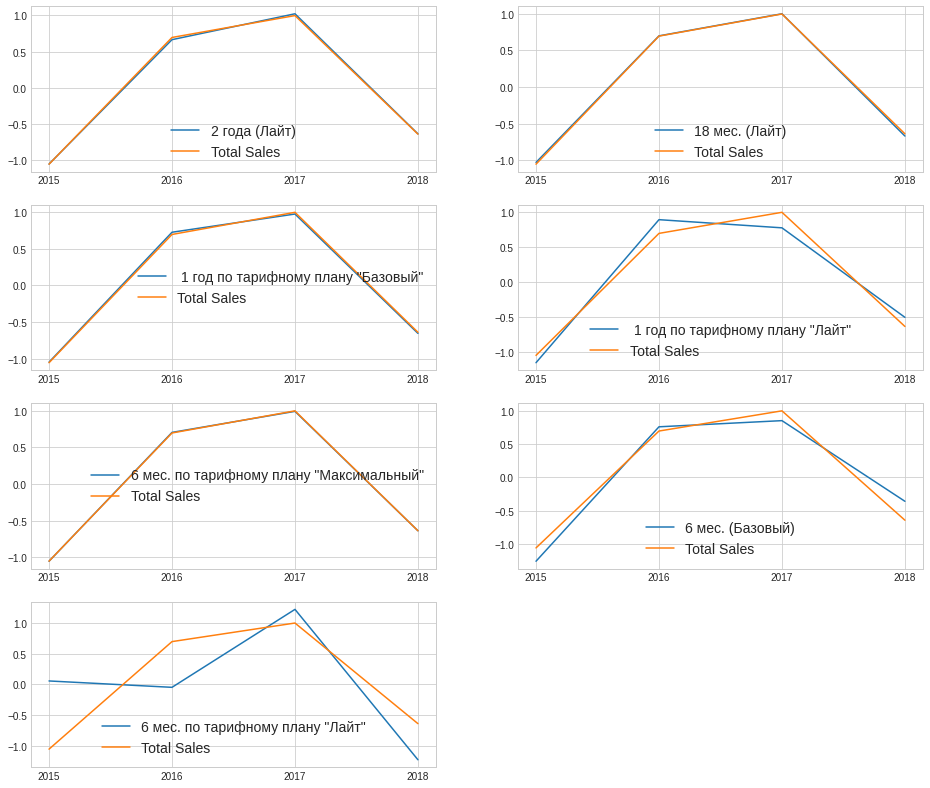

In [30]:
plt.figure(figsize = (16,14))

for i, tariff in enumerate(tariff_bk):
    plt.subplot(4,2,i+1)
    
    sales_tariff = pd.DataFrame(bills_total[(bills_total['tariff'] == tariff)].groupby(['pay_date'])['Cost'].sum())
    sales_tariff['year'] = sales_tariff.index.year
    
    sales_tariff_years = sales_tariff.groupby('year')['Cost'].sum()
    sales_tariff_years.loc[2015] *=2 
    
    sales_tariff_years_norm = (sales_tariff_years-sales_tariff_years.mean())/sales_tariff_years.std()
    plt.plot(sales_tariff_years_norm, label = tariff[48:])
    
    sales_years_norm = (sales_years-sales_years.mean())/sales_years.std()
    plt.plot(sales_years_norm, label = 'Total Sales')
  
    plt.xticks([2015, 2016, 2017, 2018])
    plt.legend()
plt.show()

Визуально можно сделать вывод, что бюджетные тарифы наиболее подвержены колебаниям относительно общего тренда. Это может быть связано как с более высокой конкуренцией в бюджетном сегменте, так и с нестабильностью существования малого и микро бизнеса.
Более строгие выводы можно сделать оценив изменения структуры рынка и целевой аудитории.

### Выводы и рекомендации
Соберем в одном месте выводы данного блока

Несмотря на кажущуюся близость плана и факта, статистический критерий говорит о том, что отклонения продаж от плана статистически значимы. План не выполняется. Практически среднее ежемесячное отклонение составляет 117тыс.руб. Что на всем периоде дает потери в 4914тыс.руб.

В целом все изменения в продажах к прошлому году и отклонения от плана укладываются в 95% доверительные интервалы для средних значений.

Однако можно заметить, что изменения относительно предыдущих лет имеют довольно высокую дисперсию, а 2018 год практически весь характеризуется падением продаж, относительно 2017го. 
Однако продажи за этот период укладывались в план, а значит падение продаж было предсказуемо и спрогнозировано заранее.

Можно обратить внимание на стабильное невыполнение годового плана СЦ Donna Miller.

Также стоит отметить  СЦ Bartumonower WorldWide Company, Varwerpackax International и Grorobor Corp.
Статистически их продажи незначительно отклоняются от планов, но их ставят антирекорды по выполнению плана.
Небольшое улучшение продаж этих СЦ могло бы довести выполнение планов до 100%. 
Либо стоит смягчить требования к планам продаж для данных СЦ, если есть объективные причины невыполнения текущих планов.

Продажи по тарифу "ТД" нулевые, однако в выборке уже оставлены счета, по которым стоит дата оплаты! 
Возможно, здесь какая-то ошибка в исходной базе?

Наибольшую часть продаж приносят долговременные тарифы на 18 и 24 месяца.
Они же наиболее стабильны с точки зрения динамики по годам.

## 2. Прогноз продаж. Оценка рынка

Сначала поймем, какими данными располагаем для оценок и прогнозов

Сделаем выборку ИП, отбирая по длине ОРГНИП - 15 знаков.
В рамках тестового задания неизвестно насколько достоверны имеющиеся данные.
Будем исходить из того, что имеем полные официальные данные по ИП.

В случае необходимости можно частично их скорректировать, опираясь на данные Федеральной Службы Информации
https://фси.рф/Main/StatisticalInformation и других источников.

In [31]:
%%time
query = ''' SELECT *
            FROM OrgStat
            WHERE length(ogrn) = 15
        '''

with sq.connect('testDB.sqlite3') as con:
    ip_base = pd.read_sql(query, con)

CPU times: user 4.91 s, sys: 384 ms, total: 5.3 s
Wall time: 5.96 s


In [32]:
ip_base.head()

,ogrn,y,revenue,personal
0,102083963730466,2014,1000.0,0.0
1,106374948255023,2014,1000.0,0.0
2,811067359865969,2014,1000.0,0.0
3,804666389595127,2014,1000.0,0.0
4,152594540068636,2014,1000.0,0.0


Для анализа и предсказаний попробуем сгенерировать ряд дополнительных признаков в разрезе по годам:
- общее число ИП за год
- число ИП без персонала
- число ИП с менее, чем 100 сотрудниками
- число ИП от 100 сотрудников
- число ИП с нулевым оборотом
- число ИП с оборотом менее 150млн.руб.
- число ИП с оборотом более 150млн.руб.

150 млн.р. и 100 сотрудников - ограничения, выше которых ИП не может оставаться на УСН.
Тем не менее, в качестве признаков оставим и количество ИП, выходящих за рамки этих ограничений.
Они тоже могут повлиять на будущий прогноз.

In [33]:
base = pd.DataFrame(ip_base.groupby('y')['ogrn'].count())

In [34]:
base['count_personal=0'] = ip_base[ip_base['personal'] <= 0].groupby('y')['ogrn'].count()
base['count_personal<100'] = ip_base[(ip_base['personal'] < 100) & (ip_base['personal'] > 0)].groupby('y')['ogrn'].count()
base['count_personal>=100'] = ip_base[ip_base['personal'] >= 100].groupby('y')['ogrn'].count()

In [35]:
base['count_revenue=0'] = ip_base[ip_base['revenue'] <= 0].groupby('y')['ogrn'].count()
base['count_revenue<150'] = ip_base[(ip_base['revenue'] < 150000000) & (ip_base['revenue'] > 0)].groupby('y')['ogrn'].count()
base['count_revenue>=150'] = ip_base[ip_base['revenue'] >= 150000000].groupby('y')['ogrn'].count()

In [36]:
base

,ogrn,count_personal=0,count_personal<100,count_personal>=100,count_revenue=0,count_revenue<150,count_revenue>=150
y,,,,,,,
2014,172673,47852,68412,56409,42519.0,128614,1540
2015,135018,3,68411,56313,NaN,133301,1717
2016,185327,52593,73710,59024,44767.0,138812,1748
2017,210552,74832,75548,60140,65689.0,143113,1750


Заметим отсутствие предпринимателей с нулевым доходом и нулевым числом персонала в 2015 году.
А также провал по общему числу ИП.
Такого определенно не может быть, поскольку нулевые ИП не могут пропасть разом все, а по данным внешних источников
Общее число ИП в эти годы росло.

Сделаем предположение, что нулевые ИП просто потерялись.
Для получения сбалансированных данных добавим в базу нулевых ИП, расчитав их число следующим образом:
orgn2014 + (ogrn2016-ogrn2014)/2 - ogrn2015

In [37]:
base.ogrn[2014] + (base.ogrn[2016] - base.ogrn[2014])/2 - base.ogrn[2015]

43982.0

In [38]:
ip_base = ip_base.append(pd.DataFrame({'ogrn': np.random.randint(10**10, 10**11, size = 43982), 
              'y':[2015]*43982, 
              'revenue':[0.]*43982, 
              'personal':[0.]*43982}), ignore_index = True)

In [39]:
base = pd.DataFrame(ip_base.groupby('y')['ogrn'].count())

base['count_personal=0'] = ip_base[ip_base['personal'] <= 0].groupby('y')['ogrn'].count()
base['count_personal<100'] = ip_base[(ip_base['personal'] < 100) & (ip_base['personal'] > 0)].groupby('y')['ogrn'].count()
base['count_personal>=100'] = ip_base[ip_base['personal'] >= 100].groupby('y')['ogrn'].count()

base['count_revenue=0'] = ip_base[ip_base['revenue'] <= 0].groupby('y')['ogrn'].count()
base['count_revenue<150'] = ip_base[(ip_base['revenue'] < 150000000) & (ip_base['revenue'] > 0)].groupby('y')['ogrn'].count()
base['count_revenue>=150'] = ip_base[ip_base['revenue'] >= 150000000].groupby('y')['ogrn'].count()

In [40]:
base

,ogrn,count_personal=0,count_personal<100,count_personal>=100,count_revenue=0,count_revenue<150,count_revenue>=150
y,,,,,,,
2014,172673,47852,68412,56409,42519,128614,1540
2015,179000,43985,68411,56313,43982,133301,1717
2016,185327,52593,73710,59024,44767,138812,1748
2017,210552,74832,75548,60140,65689,143113,1750


Теперь данные выглядят правдоподобнее

Добавим еще ряд признаков, касающийся непосредственно ЦА - ИП с оборотом менее 150млн.р. и менее 100 сотрудниками, но не нулевых:
- средний доход
- среднее число сотрудников
- количество таких ИП

А также общее число нулевых ИП

In [41]:
base['mean_revenue_CA'] = ip_base[(ip_base['revenue'] < 150000000) &\
                                      (ip_base['personal'] < 100) &\
                                      (ip_base['revenue'] > 0) &\
                                      (ip_base['personal'] > 0)].groupby('y')['revenue'].mean()
base['mean_personal_CA'] = ip_base[(ip_base['revenue'] < 150000000) &\
                                      (ip_base['personal'] < 100) &\
                                      (ip_base['revenue'] > 0) &\
                                      (ip_base['personal'] > 0)].groupby('y')['personal'].mean()

In [42]:
base['count_CA'] = ip_base[(ip_base['revenue'] < 150000000) &\
                                      (ip_base['personal'] < 100)].groupby('y')['ogrn'].count()

base['count_zero'] = ip_base[(ip_base['revenue'] <= 0) &\
                                      (ip_base['personal'] <= 0)].groupby('y')['ogrn'].count()

In [43]:
base

,ogrn,count_personal=0,count_personal<100,count_personal>=100,count_revenue=0,count_revenue<150,count_revenue>=150,mean_revenue_CA,mean_personal_CA,count_CA,count_zero
y,,,,,,,,,,,
2014,172673,47852,68412,56409,42519,128614,1540,857074.621664,31.469889,116100,39049
2015,179000,43985,68411,56313,43982,133301,1717,874994.228220,30.786310,112327,43982
2016,185327,52593,73710,59024,44767,138812,1748,929580.225381,30.484939,126124,40999
2017,210552,74832,75548,60140,65689,143113,1750,958726.572080,30.422956,150184,61711


Глядя на полученные данные, можно сделать вывод, что с 2014 по 2017 годы происходил стабильный рост активности ИП. 
Растет как число "нулевых" ИП, так и количество ИП из целевой аудитории.

Сопоставим данные с объемами продаж по годам

Чтобы посчитать реальную долю рынка нам необходимо отойти от заданных условий и оценить продажи не только по продукту Бухгалтерия.Контур, но и по другим, через которые наша ЦА также может отправлять отчетность - Эльба и Контур-Экстрен

Сгруппируем базу целевых(тех, кто хотя бы раз за 4 года оставался в рамках требований по УСН) ИП по ОГРН, чтобы получить уникальные записи по каждому ИП.
Затем "смёрджим" базу оплаченных счетов с базой целевых ИП, получив базу счетов, оплаченных целевой аудиторией по всем подходящим продуктам. И посмотрим в разрезе продуктов и лет.

In [44]:
test = ip_base[(ip_base['revenue'] < 150000000) & (ip_base['personal'] < 100)].groupby('ogrn').mean()

In [45]:
bills_total.merge(test, how = 'inner', on = 'ogrn').groupby(['product', 'year'])['Cost'].agg(['sum', 'count'])

sum  count
product                     year                  
Бухгалтерия.Контур          2015   66441.89   4949
                            2016  174122.73  12684
                            2017  183356.24  12976
                            2018  154185.83  10470
Контур-Экстерн              2017   15090.30   1695
                            2018  110524.50  12567
Контур-Экстерн Малый Бизнес 2018   83155.20  10507
Эльба                       2016  353700.00  15144
                            2017  363436.20  15567
                            2018  288522.00  12386

Видно, что Бухгалтерия.Контур составляет только малую часть продаж искомой ЦА. Далее будем отталкиваться от продаж по всем продуктам

In [46]:
sales_stat = bills_total.merge(test, how = 'inner', on = 'ogrn').groupby(['year'])['Cost'] \
                                                                .agg(['sum', 'mean', 'count'])
sales_stat

,sum,mean,count
year,,,
2015,66441.89,13.425316,4949
2016,527822.73,18.967325,27828
2017,561882.74,18.582007,30238
2018,636387.53,13.855596,45930


Здесь мы видим, что общий объем продаж на целевом рынке растет. Теперь хорошо видно, что падение продаж Бухгалтерии.Контур в 2018м было успешно компенсировано продажами продуктов-заменителей. А значит провала 2018 по целевому рынку на самом деле не было.

In [47]:
base.loc[2018] = np.nan
base.loc[2019] = np.nan

In [48]:
# распространяем оценку среднего объема продаж с полугода на весь 2015год

sales_stat['sum'][2015] *= 2
sales_stat['count'][2015] *= 2

<ipython-input-48-962e87f06422>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sales_stat['sum'][2015] *= 2
<ipython-input-48-962e87f06422>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sales_stat['count'][2015] *= 2


In [49]:
sales_stat

,sum,mean,count
year,,,
2015,132883.78,13.425316,9898
2016,527822.73,18.967325,27828
2017,561882.74,18.582007,30238
2018,636387.53,13.855596,45930


Добавим к базе признаков статистики по продажам и расчитаем емкость рынка и долю Контура по известным данным

In [50]:
base['sales_sum'] = sales_stat['sum']
base['sales_mean'] = sales_stat['mean']
base['sales_count'] = sales_stat['count']

base['market_capacity'] = base['count_CA']*base['sales_mean']
base['kontur_market_share'] = base['sales_sum']/base['market_capacity']
base

,ogrn,count_personal=0,count_personal<100,count_personal>=100,count_revenue=0,count_revenue<150,count_revenue>=150,mean_revenue_CA,mean_personal_CA,count_CA,count_zero,sales_sum,sales_mean,sales_count,market_capacity,kontur_market_share
y,,,,,,,,,,,,,,,,
2014,172673.0,47852.0,68412.0,56409.0,42519.0,128614.0,1540.0,857074.621664,31.469889,116100.0,39049.0,NaN,NaN,NaN,NaN,NaN
2015,179000.0,43985.0,68411.0,56313.0,43982.0,133301.0,1717.0,874994.228220,30.786310,112327.0,43982.0,132883.78,13.425316,9898.0,1.508025e+06,0.088118
2016,185327.0,52593.0,73710.0,59024.0,44767.0,138812.0,1748.0,929580.225381,30.484939,126124.0,40999.0,527822.73,18.967325,27828.0,2.392235e+06,0.220640
2017,210552.0,74832.0,75548.0,60140.0,65689.0,143113.0,1750.0,958726.572080,30.422956,150184.0,61711.0,561882.74,18.582007,30238.0,2.790720e+06,0.201340
2018,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,636387.53,13.855596,45930.0,NaN,NaN
2019,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [51]:
# оценим корреляции наших показателей с объемом продаж

base.dropna().corrwith(base.sales_sum)

ogrn                   0.707352
count_personal=0       0.763605
count_personal<100     0.983999
count_personal>=100    0.976766
count_revenue=0        0.586686
count_revenue<150      0.928277
count_revenue>=150     0.999849
mean_revenue_CA        0.961475
mean_personal_CA      -0.996073
count_CA               0.821146
count_zero             0.445266
sales_sum              1.000000
sales_mean             0.991065
sales_count            0.999309
market_capacity        0.972075
kontur_market_share    0.978718
dtype: float64

Видим, что продажи продукта сильно коррелируют с половиной полученных признаков тех же лет.

В ходе ручного перебора взаимных корреляций, который я опущу, было выделено 4 признака, которых должно быть достаточно для прогнозирования: 
- средний оборот ЦА
- объем ЦА
- число "нулевых" ИП
- и сам объем продаж, как целевой сигнал

In [52]:
final_cols = ['mean_revenue_CA', 'count_CA', 'count_zero', 'sales_sum']
base.dropna()[final_cols].corr()

,mean_revenue_CA,count_CA,count_zero,sales_sum
mean_revenue_CA,1.000000,0.946397,0.674249,0.961475
count_CA,0.946397,1.000000,0.876649,0.821146
count_zero,0.674249,0.876649,1.000000,0.445266
sales_sum,0.961475,0.821146,0.445266,1.000000


In [53]:
base[final_cols]

,mean_revenue_CA,count_CA,count_zero,sales_sum
y,,,,
2014,857074.621664,116100.0,39049.0,NaN
2015,874994.228220,112327.0,43982.0,132883.78
2016,929580.225381,126124.0,40999.0,527822.73
2017,958726.572080,150184.0,61711.0,561882.74
2018,NaN,NaN,NaN,636387.53
2019,NaN,NaN,NaN,NaN


Теперь можно заняться прогнозами
На базе этих признаков сначала спрогнозируем изменение самих признаков, и далее через них - изменение емкости рынка, продажи и доля Контура

### Прогноз рыночных показателей

Нужные нам показатели спрогнозируем простой линейной регрессией на временную шкалу

In [54]:
from sklearn.linear_model import Lasso, Ridge
from sklearn.metrics import mean_squared_error

import warnings
warnings.filterwarnings('ignore')

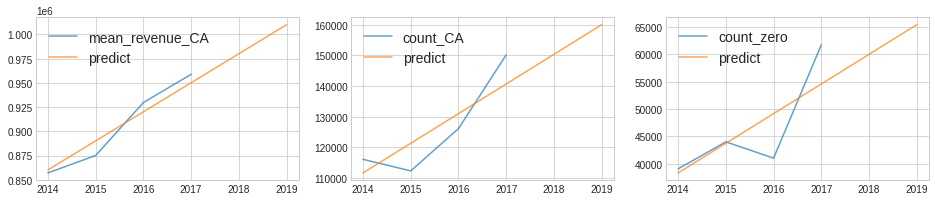

In [66]:
plt.figure(figsize = (16,3))

features_list = ['mean_revenue_CA', 'count_CA', 'count_zero']

for i, feature in enumerate(features_list):
    plt.subplot(1,3,i+1)
    
    y = base[feature].iloc[:-2]
    x = np.array([2014, 2015, 2016, 2017, 2018, 2019]).reshape(-1,1)
    
    lr = Ridge()
    lr.fit(x[:-2],y)
        
    plt.plot(y, label = feature,  alpha=0.7)
    plt.plot(x, lr.predict(x), alpha = 0.7, label = 'predict')

#      base[feature].iloc[-2:] = lr.predict(x[-2:])
    
    plt.legend()
    plt.xticks([2014, 2015, 2016, 2017, 2018, 2019])
plt.show()

In [67]:
base[final_cols]

,mean_revenue_CA,count_CA,count_zero,sales_sum
y,,,,
2014,8.570746e+05,116100.000,39049.000000,NaN
2015,8.749942e+05,112327.000,43982.000000,132883.78
2016,9.295802e+05,126124.000,40999.000000,527822.73
2017,9.587266e+05,150184.000,61711.000000,561882.74
2018,9.799985e+05,150360.625,59977.541667,636387.53
2019,1.009960e+06,160031.375,65394.458333,NaN


### Емкость рынка ИП УСН 2015-2019гг.

Спрогнозируем с помощью регрессии на значения предсказанных признаков выше.

In [68]:
capacity = base[features_list+['market_capacity']]
capacity

,mean_revenue_CA,count_CA,count_zero,market_capacity
y,,,,
2014,8.570746e+05,116100.000,39049.000000,NaN
2015,8.749942e+05,112327.000,43982.000000,1.508025e+06
2016,9.295802e+05,126124.000,40999.000000,2.392235e+06
2017,9.587266e+05,150184.000,61711.000000,2.790720e+06
2018,9.799985e+05,150360.625,59977.541667,NaN
2019,1.009960e+06,160031.375,65394.458333,NaN


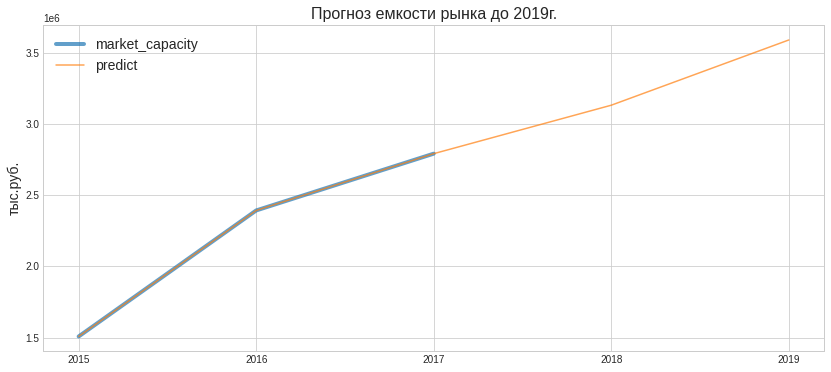

In [69]:
plt.figure(figsize = (14,6))
    
y = capacity.iloc[1:4]['market_capacity']
x = capacity.drop('market_capacity', axis = 1).iloc[1:4]
x_pred = capacity.drop('market_capacity', axis = 1).iloc[1:]

lr = Ridge()
lr.fit(x, y)

plt.plot(y, label = 'market_capacity',  alpha=0.7, lw = 4)
plt.plot(x_pred.index, lr.predict(x_pred), alpha = 0.7, label = 'predict')

capacity['market_capacity'].iloc[-2:] = lr.predict(x_pred)[-2:]

plt.legend()
plt.xticks([2015, 2016, 2017, 2018, 2019])
plt.title('Прогноз емкости рынка до 2019г.')
plt.ylabel('тыс.руб.')

plt.show()

In [70]:
capacity

,mean_revenue_CA,count_CA,count_zero,market_capacity
y,,,,
2014,8.570746e+05,116100.000,39049.000000,NaN
2015,8.749942e+05,112327.000,43982.000000,1.508025e+06
2016,9.295802e+05,126124.000,40999.000000,2.392235e+06
2017,9.587266e+05,150184.000,61711.000000,2.790720e+06
2018,9.799985e+05,150360.625,59977.541667,3.130704e+06
2019,1.009960e+06,160031.375,65394.458333,3.588435e+06


### Прогноз продаж на рынке ИП УСН Контур на 2019 г.

In [71]:
capacity['sales'] = base['sales_sum'].copy()
capacity

,mean_revenue_CA,count_CA,count_zero,market_capacity,sales
y,,,,,
2014,8.570746e+05,116100.000,39049.000000,NaN,NaN
2015,8.749942e+05,112327.000,43982.000000,1.508025e+06,132883.78
2016,9.295802e+05,126124.000,40999.000000,2.392235e+06,527822.73
2017,9.587266e+05,150184.000,61711.000000,2.790720e+06,561882.74
2018,9.799985e+05,150360.625,59977.541667,3.130704e+06,636387.53
2019,1.009960e+06,160031.375,65394.458333,3.588435e+06,NaN


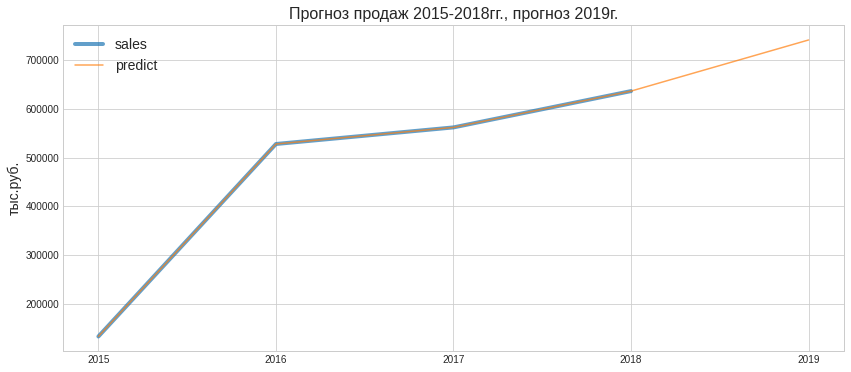

In [72]:
plt.figure(figsize = (14,6))
    
y = capacity.iloc[1:5]['sales']
x = capacity.drop('sales', axis = 1).iloc[1:5]
x_pred = capacity.drop('sales', axis = 1).iloc[1:]

lr = Ridge()
lr.fit(x, y)

plt.plot(y, label = 'sales',  alpha=0.7, lw = 4)
plt.plot(x_pred.index, lr.predict(x_pred), alpha = 0.7, label = 'predict')

capacity['sales'].iloc[-1] = lr.predict(x_pred)[-1]

plt.legend()
plt.xticks([2015, 2016, 2017, 2018, 2019])
plt.title('Прогноз продаж 2015-2018гг., прогноз 2019г.')
plt.ylabel('тыс.руб.')

plt.show()

In [73]:
capacity

,mean_revenue_CA,count_CA,count_zero,market_capacity,sales
y,,,,,
2014,8.570746e+05,116100.000,39049.000000,NaN,NaN
2015,8.749942e+05,112327.000,43982.000000,1.508025e+06,132883.780000
2016,9.295802e+05,126124.000,40999.000000,2.392235e+06,527822.730000
2017,9.587266e+05,150184.000,61711.000000,2.790720e+06,561882.740000
2018,9.799985e+05,150360.625,59977.541667,3.130704e+06,636387.530000
2019,1.009960e+06,160031.375,65394.458333,3.588435e+06,741292.846247


### Доля рынка, Контур

In [74]:
capacity['market_share'] = capacity.sales/capacity.market_capacity*100
capacity

,mean_revenue_CA,count_CA,count_zero,market_capacity,sales,market_share
y,,,,,,
2014,8.570746e+05,116100.000,39049.000000,NaN,NaN,NaN
2015,8.749942e+05,112327.000,43982.000000,1.508025e+06,132883.780000,8.811773
2016,9.295802e+05,126124.000,40999.000000,2.392235e+06,527822.730000,22.064001
2017,9.587266e+05,150184.000,61711.000000,2.790720e+06,561882.740000,20.133969
2018,9.799985e+05,150360.625,59977.541667,3.130704e+06,636387.530000,20.327295
2019,1.009960e+06,160031.375,65394.458333,3.588435e+06,741292.846247,20.657834


Text(0, 0.5, '%')

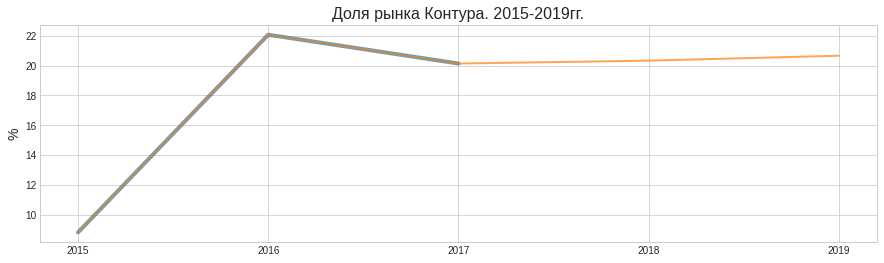

In [75]:
plt.figure(figsize = (15,4))

plt.plot(capacity['market_share'].iloc[:-2],  alpha=0.7, lw = 4)
plt.plot(capacity['market_share'],  alpha=0.7, lw = 2)

plt.xticks([2015, 2016, 2017, 2018, 2019])
plt.title('Доля рынка Контура. 2015-2019гг.')
plt.ylabel('%')

### Выводы и рекомендации

1. Рынок продолжaет расти
    
2. При текущей динамике Контур останется в рынке, сохраняя текущую долю

3. Бухгалтерия.Контур составляет только малую часть продаж искомой ЦА. 

4. Общий объем продаж на целевом рынке растет. Падение продаж Бухгалтерии.Контур в 2018м было успешно компенсировано продажами продуктов-заменителей. А значит провала 2018 по целевому рынку на самом деле не было.

5. Признаки, позволяющие достаточно правдоподобно спрогнозировать продажи(хотя, конечно, данных для хорошей модели слишком мало):
    - средний оборот ЦА
    - объем ЦА
    - число "нулевых" ИП